# Time Variant Pitch Shifting by Time Scale Modification via Overlap and Add and Resampling

This pitch-shifting algorithm should take a time variant pitch-shifting factor $\rho$ for time variant pitch-shifting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# define default samplerate of 44100Hz and not 22050Hz for librosa
# and fft length and hop size
from presets import Preset
import librosa as _librosa
import librosa.display as _display
_librosa.display = _display
librosa = Preset(_librosa)

librosa['sr'] = 44100
librosa['n_fft'] = 4096
librosa_hop_len = 2048
librosa['hop_length'] = librosa_hop_len

import IPython

16384


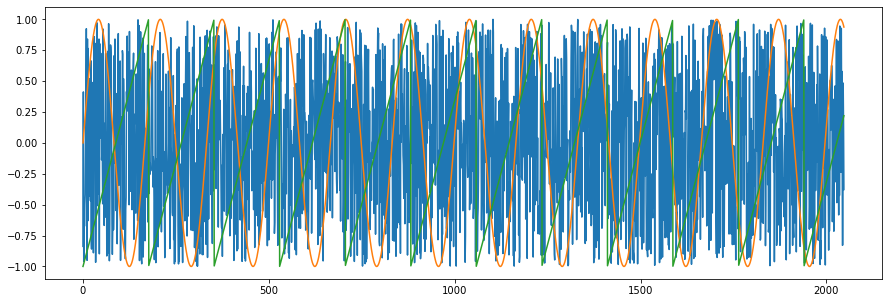

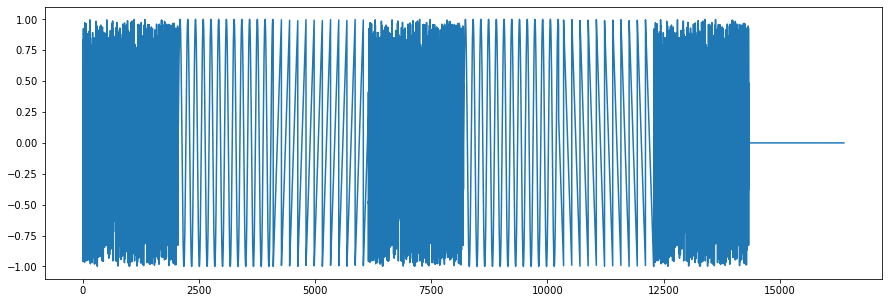

In [2]:
sr = 44100

# generate a unique input signal to check, what is going on
n_samples = 2048

# noise
noise = (np.random.rand(n_samples) - 0.5) * 2

# sine
f = 265
omega = 2 * np.pi * f
t = np.linspace(0, n_samples / sr, n_samples)
sine = np.sin(omega * t)

# sawtooth
a = 500
saw = (((t * a) % 2) - 1)

plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(noise)
plt.plot(sine)
plt.plot(saw)

x_part = np.concatenate((noise, sine, saw, noise, sine, saw[::-1], noise, np.zeros(n_samples)))
plt.figure()
plt.plot(x_part)

print(x_part.size)

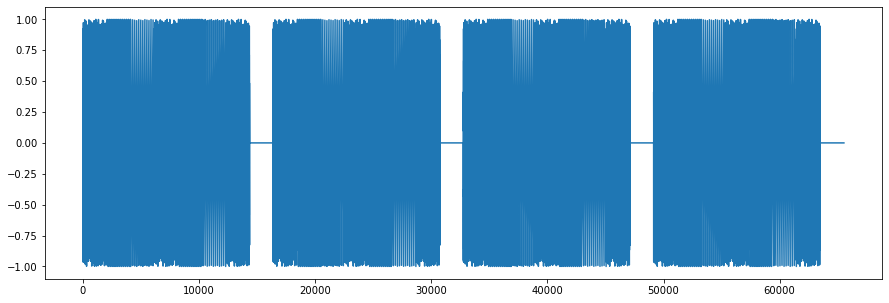

In [3]:
# input signal
x = np.concatenate((x_part, x_part, x_part, x_part))
plt.plot(x)

In [4]:
# rho was analyzed by a pitch tracking algorithm with a certain window-size and hop-size, so choose one
pitch_win_size = 4096
pitch_hop_size = 1024

# how many pitch marks are needed?
n_pitches = (x.size - pitch_win_size) // pitch_hop_size
print(n_pitches)

60


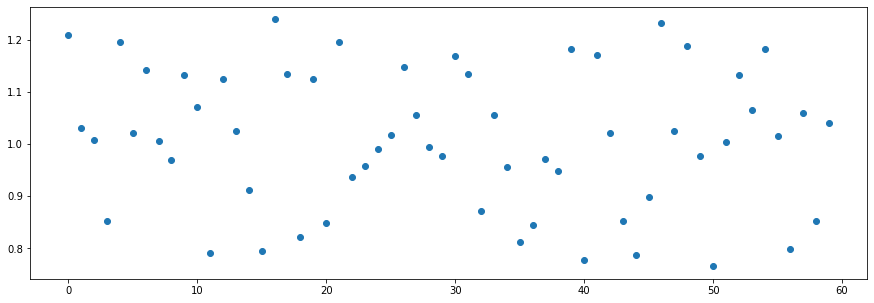

In [5]:
# generate a rho around the value 1
rho = 1 + (np.random.rand(n_pitches) - 0.5) * 0.5

plt.plot(rho, 'o')

## Time varying pitch shifting using TSM by OLA and resampling.

* x...input signal to be pitch shifted
* sr...sample rate of x
* rho...time varying pitch-shifting factor
* rho_N...window size of the validity of the pitch-shifting factor
* N...analysis window size of pitch shifting
* overlap_factor...factor of window overlap for OLA

In [6]:
# The length of the validity of the pitch marks is the pitch-tracking hop size
rho_N = pitch_hop_size

# choose an analysis window size and an overlap factor for the pitch-shifting algorithm
N = 512
overlap_factor = 2

## The actual pitch-shifting algorithm

In [7]:
# output signal
y = np.zeros(N)

# window
w = np.hanning(N)

# analysis hop size
Sa = N // overlap_factor

# How many blocks do we have to process?
n_blocks = (x.size - pitch_win_size) // Sa

print("x.len:", x.size, "Sa:", Sa, "n_blocks:", n_blocks)

# How many blocks use the same pitch mark?
n_blocks_per_rho = n_blocks // rho.size

# format pitch-shifting factor to processing parameters
rho_formated = np.repeat(rho, n_blocks_per_rho)
print("n_blocks_per_rho:", n_blocks_per_rho, "rho_formated.size:", rho_formated.size)

x.len: 65536 Sa: 256 n_blocks: 240
n_blocks_per_rho: 4 rho_formated.size: 240


In [8]:
# main processing loop
for i in range(n_blocks):
    # pitch-shifting factor
    r = rho_formated[i]
    # time-scaling factor
    alpha = 1 / r

    block = x[i*Sa : i*Sa+N] * w

    if not np.isnan(r): # voiced
        resampled_block = librosa.resample(block, sr, sr*alpha)
    else: # unvoiced (no pitch shifting)
        alpha = 1
        resampled_block = block
        
    Ss = int(alpha * Sa)
    head = y[:-(N-Ss)]
    overlap = y[-(N-Ss):] + resampled_block[:N-Ss]
    tail = resampled_block[N-Ss:]
    y = np.concatenate((head, overlap, tail))

x.size: 65536 y.size 63684


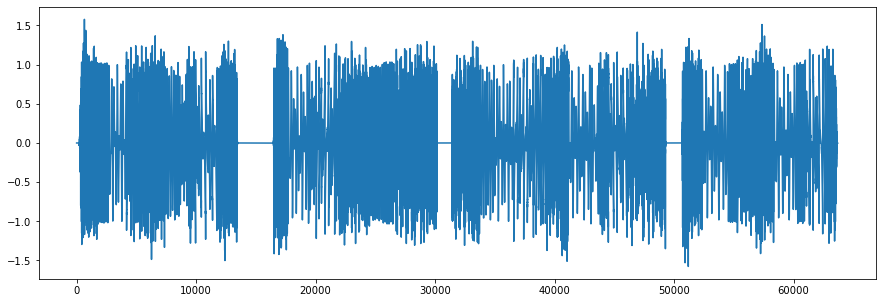

In [9]:
print("x.size:", x.size, "y.size", y.size)
plt.plot(y)

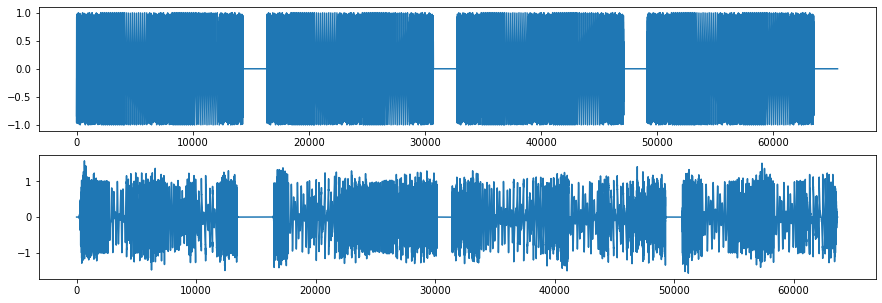

In [10]:
fig, axs = plt.subplots(2)
axs[0].plot(x)
axs[1].plot(y)

## Analysis

This looks lika a wrong result because these signals should be approximately the same size!
y should one pitch-analysis block size smaller than x.

Let's debug the main processing loop and check the algorithm step by step.


### The Algorithm

$\alpha$ is the pitch-shifting factor.

We start to change the pitch of the original signal by resampling it by a factor of $\frac{1}{\alpha}$.
Because this changes the length of the signal, we use a TSM method to preserve the duration of the original signal.
The time duration of the resampled signal should be scaled by a factor equal to $\alpha$.

Let's suppose we want to shift the pitch of a sinosoid up by an octave.
So we have to resample the sinosoid by the resampling factor $r = \frac{f_0}{f_{out}} = \frac{1}{\alpha}$, where $f_0$ is the frequency of the sinusoid and $f_{out}$ is the target frequency or the frequency of the pitch shifted signal.

In [11]:
f_0 = 500
f_out = 2*f_0 # shift by an octave

r = f_0/f_out
alpha = 1/r
print("The original frequency of the signal is", f_0, "and the target frequency of the output signal is", f_out, ".")
print("So the resampling factor r is", r, "and the time scaling factor alpha is", alpha, ".")

The original frequency of the signal is 500 and the target frequency of the output signal is 1000 .
So the resampling factor r is 0.5 and the time scaling factor alpha is 2.0 .


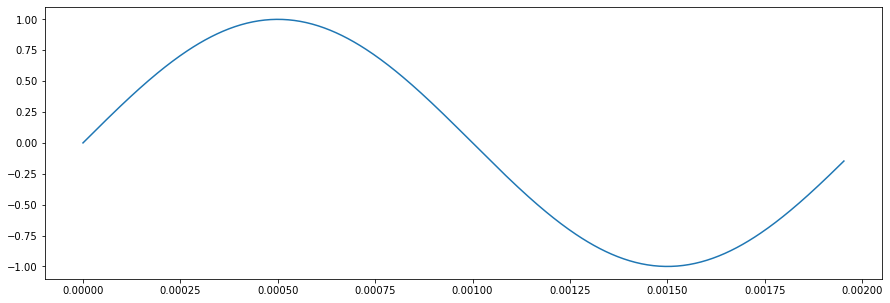

In [12]:
# make the input signal
n_samples = 512
t = np.linspace(0, 1/n_samples, n_samples)
omega = 2 * np.pi * f_0
x = np.sin(omega * t)

plt.plot(t, x)

### Resampling

Resampling is done by the resampling factor $r = \frac{f_{s,target}}{f_{s,orig}}$ where $f_{s,orig}$ is the original sampling rate of the signal and $f_{s,target}$ is the target sampling rate.

If we want to increase the frequency of a signal, we want to play it faster.
This is equivalent to increasing the sampling rate of our playing device or decreasing the sampling rate $f_{s,target}$ of our sample.
Since we want to have a fixed sampling rate for our replaying system, we decrease the sampling rate of our sample.

Original sampling rate is 44100 and target sampling rate is 22050.0


Text(0.5, 1.0, 'resampled')

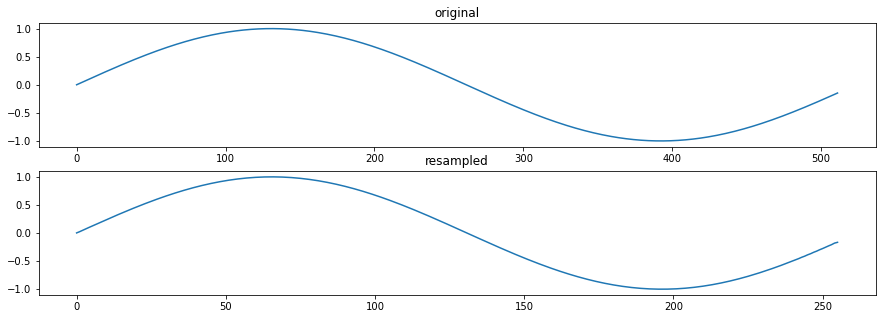

In [13]:
f_s_orig = 44100

f_s_target = f_s_orig * r
print("Original sampling rate is", f_s_orig, "and target sampling rate is", f_s_target)

x_resampled = librosa.resample(x, f_s_orig, f_s_target)

fig, axs = plt.subplots(2)
axs[0].plot(x)
axs[0].set_title("original")
axs[1].plot(x_resampled)
axs[1].set_title("resampled")

To proove this, we make an audio example:

In [14]:
dur = 2 # seconds
t = np.arange(0, dur, 1/f_s_orig)
x_audio = np.sin(2 * np.pi * f_0 * t)

IPython.display.Audio(x_audio, rate=f_s_orig)

In [15]:
x_audio_resampled = librosa.resample(x_audio, f_s_orig, f_s_target)

IPython.display.Audio(x_audio_resampled, rate=f_s_orig)

Note, that the resampled signal to a higher signal-frequency (or pitch) has a shorter length.
You can see this by the amount of samples in the plots above and by the showed signal length in the audio player.
This has to be fixed by time scale modification according to $\alpha$.
An $\alpha > 1$ is time tretching and an $\alpha < 1$ is time compression.

Let's define a time scale modification function:

In [16]:
def tsm_ola(x, alpha, N=1024, overlap_factor=4):
    """
    Time Scale Modification by windowed Overlap and Add
    x...input signal to be time scaled
    alpha...time scale factor (alpha>1: time stretching; alpha<1: time compression)
    N...used block length
    overlap_factor...number of overlaping analysis blocks
    """
    if(alpha > overlap_factor):
        print("Error: alpha must be less than or ephal to the overlap factor!")
        print("Reduce alpha or increase the overlap factor.")
        return None

    # window
    win = np.hanning(N)

    # analysis hop size
    Sa = N // overlap_factor
    # synthesis hop size
    Ss = round(alpha * Sa)

    n_blocks = (x.size - N) // Sa
    y = np.zeros(round(x.size * alpha))

    # first block
    last = np.copy(x[:N] * win)
    y[:Ss] = last[:Ss]

    for i in range(1, n_blocks):
        current = x[i*Sa : i*Sa + N] * win

        overlap = last[Ss:] + current[:N-Ss]
        tail = current[N-Ss:]

        last = np.concatenate((overlap, tail))
        y[i*Ss:(i+1)*Ss] = last[:Ss]
    
    return y

Now if we apply the time scaling with the $\alpha = 2$, we successfully did the pitch shift to an octave without altering the length of the signal.

y.size: 88200


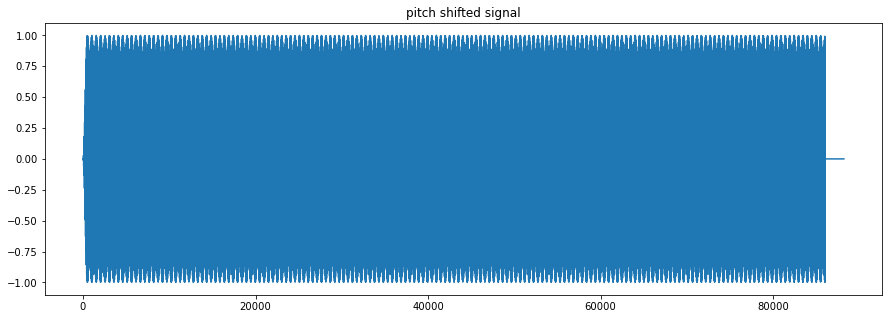

In [17]:
y = tsm_ola(x_audio_resampled, alpha, overlap_factor=4)

print("y.size:", y.size)
plt.plot(y)
plt.title("pitch shifted signal")
IPython.display.Audio(y, rate=f_s_orig)

This algorithm has poor quality and produces a lot of artifacts, but it works.
The output signal is a pitch shifted version of the input signal.
We can hear the amplitude modulation of the windowing.

Let's try a pitch shift to a lower frequency.

In [18]:
f_0 = 500   # current frequency
f_out = 400 # target frequency
f_s_orig = 44100

# signal to be processed
dur = 2 # seconds
t = np.arange(0, dur, 1/f_s_orig)
x_audio = np.sin(2 * np.pi * f_0 * t)

r = f_0/f_out
alpha = 1/r

print("The original frequency of the signal is", f_0, "and the target frequency of the output signal is", f_out, ".")
print("So the resampling factor r is", r, "and the time scaling factor alpha is", alpha, ".")
print("original length:", x_audio.size)
IPython.display.Audio(x_audio, rate=f_s_orig)

The original frequency of the signal is 500 and the target frequency of the output signal is 400 .
So the resampling factor r is 1.25 and the time scaling factor alpha is 0.8 .
original length: 88200


In [21]:
# resampling
f_s_target = f_s_orig * r
x_audio_resampled = librosa.resample(x_audio, f_s_orig, f_s_target)

print("Original sampling rate is", f_s_orig, "and target sampling rate is", f_s_target)
print("resampled length:", x_audio_resampled.size)
IPython.display.Audio(x_audio_resampled, rate=f_s_orig)

Original sampling rate is 44100 and target sampling rate is 55125.0
resampled length: 110250


In [36]:
y = tsm_ola(x_audio_resampled, alpha, N=2048, overlap_factor=4)

print("pitch-shifted length:", y.size)
IPython.display.Audio(y, rate=f_s_orig)

pitch-shifted length: 88200


There is a slight pitch mismatch between the resampled signal `x_audio_resampled` and the final output signal `y`, but otherwise this method works.